In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from copy import deepcopy

In [2]:
df = pd.read_csv('MSFT.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060163,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062311,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063386,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061774,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060700,47894400
...,...,...,...,...,...,...,...
9561,2024-02-21,400.170013,402.290009,397.220001,402.179993,402.179993,18631100
9562,2024-02-22,410.190002,412.829987,408.570007,411.649994,411.649994,27009900
9563,2024-02-23,415.670013,415.859985,408.970001,410.339996,410.339996,16284800
9564,2024-02-26,411.459991,412.160004,407.359985,407.540009,407.540009,16193500


In [3]:
df = df[['Date', 'Close']]

df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9561,2024-02-21,402.179993
9562,2024-02-22,411.649994
9563,2024-02-23,410.339996
9564,2024-02-26,407.540009


In [4]:
df['Date']

0       1986-03-13
1       1986-03-14
2       1986-03-17
3       1986-03-18
4       1986-03-19
           ...    
9561    2024-02-21
9562    2024-02-22
9563    2024-02-23
9564    2024-02-26
9565    2024-02-27
Name: Date, Length: 9566, dtype: object

In [5]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [6]:
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9561,2024-02-21,402.179993
9562,2024-02-22,411.649994
9563,2024-02-23,410.339996
9564,2024-02-26,407.540009


In [7]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

C:\Users\JC\AppData\Local\Temp\ipykernel_13500\2565755782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9561   2024-02-21
9562   2024-02-22
9563   2024-02-23
9564   2024-02-26
9565   2024-02-27
Name: Date, Length: 9566, dtype: datetime64[ns]

In [8]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-02-21,402.179993
2024-02-22,411.649994
2024-02-23,410.339996


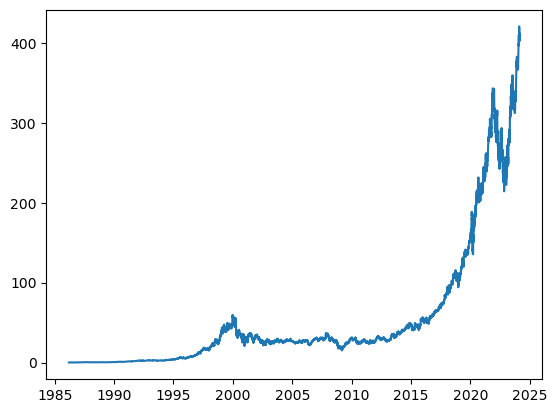

In [9]:
plt.plot(df.index, df['Close'])

In [10]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [11]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

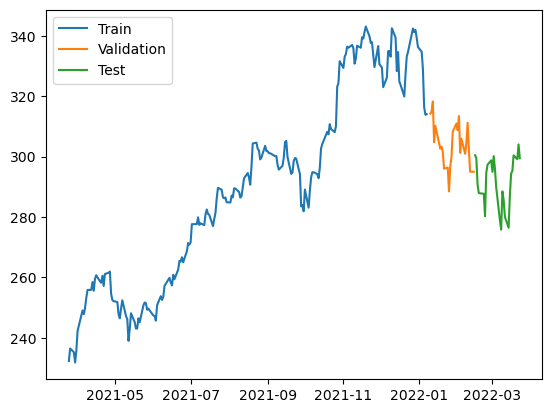

In [12]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [13]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


Epoch 1/100


7/7 [==============================] - 9s 223ms/step - loss: 84623.2500 - mean_absolute_error: 289.1589 - val_loss: 92381.1484 - val_mean_absolute_error: 303.8555
Epoch 2/100
7/7 [==============================] - 0s 14ms/step - loss: 84477.8281 - mean_absolute_error: 288.9079 - val_loss: 92201.4609 - val_mean_absolute_error: 303.5597
Epoch 3/100
7/7 [==============================] - 0s 14ms/step - loss: 84292.4141 - mean_absolute_error: 288.5878 - val_loss: 91980.8281 - val_mean_absolute_error: 303.1961
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 84056.7578 - mean_absolute_error: 288.1784 - val_loss: 91684.9688 - val_mean_absolute_error: 302.7078
Epoch 5/100
7/7 [==============================] - 0s 14ms/step - loss: 83738.2109 - mean_absolute_error: 287.6242 - val_loss: 91272.2812 - val_mean_absolute_error: 302.0253
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 83271.4688 - mean_absolute_error: 286.8117 - val_loss:

7/7 [==============================] - 0s 13ms/step - loss: 973.6951 - mean_absolute_error: 26.3623 - val_loss: 243.6453 - val_mean_absolute_error: 13.9932
Epoch 45/100
7/7 [==============================] - 0s 15ms/step - loss: 969.8715 - mean_absolute_error: 26.3175 - val_loss: 231.9455 - val_mean_absolute_error: 13.5985
Epoch 46/100
7/7 [==============================] - 0s 15ms/step - loss: 965.2899 - mean_absolute_error: 26.2444 - val_loss: 256.1089 - val_mean_absolute_error: 14.4055
Epoch 47/100
7/7 [==============================] - 0s 15ms/step - loss: 966.8343 - mean_absolute_error: 26.2787 - val_loss: 239.1311 - val_mean_absolute_error: 13.8497
Epoch 48/100
7/7 [==============================] - 0s 15ms/step - loss: 965.0967 - mean_absolute_error: 26.2639 - val_loss: 254.3789 - val_mean_absolute_error: 14.3543
Epoch 49/100
7/7 [==============================] - 0s 16ms/step - loss: 957.2958 - mean_absolute_error: 26.1359 - val_loss: 243.6663 - val_mean_absolute_error: 14.0020

Epoch 93/100
7/7 [==============================] - 0s 12ms/step - loss: 55.9540 - mean_absolute_error: 5.8927 - val_loss: 33.2352 - val_mean_absolute_error: 4.8654
Epoch 94/100
7/7 [==============================] - 0s 13ms/step - loss: 48.9871 - mean_absolute_error: 5.3775 - val_loss: 34.7142 - val_mean_absolute_error: 4.8826
Epoch 95/100
7/7 [==============================] - 0s 13ms/step - loss: 44.1991 - mean_absolute_error: 5.0138 - val_loss: 39.3454 - val_mean_absolute_error: 5.0348
Epoch 96/100
7/7 [==============================] - 0s 13ms/step - loss: 44.7441 - mean_absolute_error: 5.1322 - val_loss: 38.8035 - val_mean_absolute_error: 5.0107
Epoch 97/100
7/7 [==============================] - 0s 13ms/step - loss: 39.9740 - mean_absolute_error: 4.8309 - val_loss: 45.6190 - val_mean_absolute_error: 5.3222
Epoch 98/100
7/7 [==============================] - 0s 15ms/step - loss: 35.0626 - mean_absolute_error: 4.4351 - val_loss: 56.7162 - val_mean_absolute_error: 5.8796
Epoch 99/1

7/7 [==============================] - 1s 12ms/step


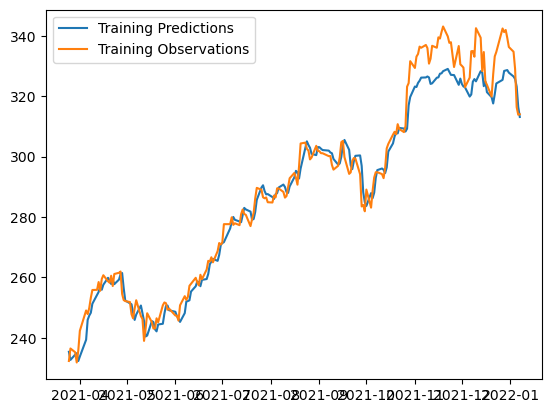

In [14]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 30ms/step


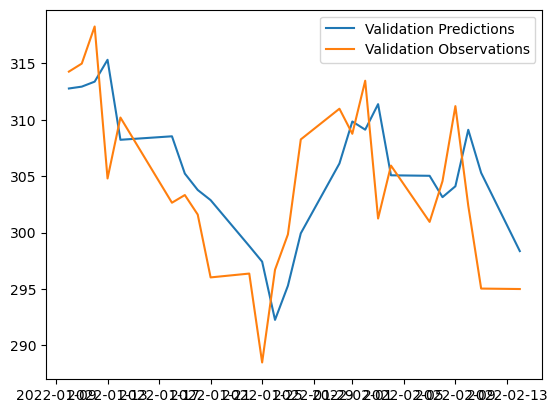

In [15]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 32ms/step


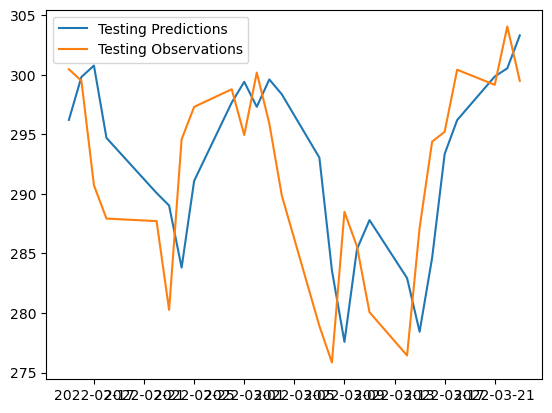

In [16]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

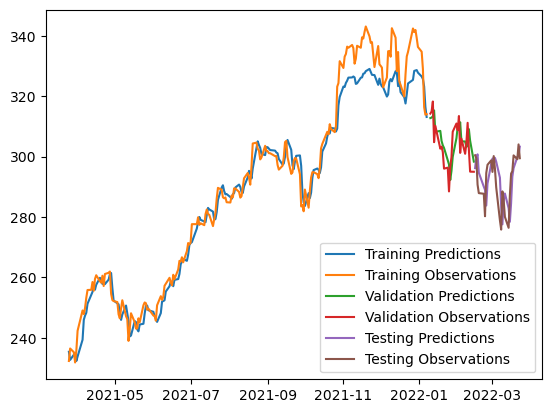

In [17]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [18]:
recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 39ms/step


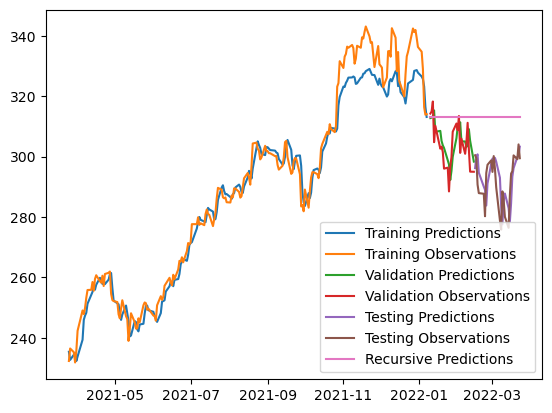

In [19]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])